# Librerías

In [2]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

from sklearn.model_selection import train_test_split
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

import math

# Preprocesamiento de datos de entrada

In [3]:
# preparaing data
df_train = pd.read_csv('train.csv')

df_train['Pclass'] = df_train['Pclass'].astype(str)

df_train = pd.concat([df_train, pd.get_dummies(df_train[['Pclass', 'Sex', 'Embarked']])], axis=1)

# I will fill missings with the median
df_train['Age'] = df_train['Age'].fillna(df_train['Age'].median())

df_train['is_child'] = df_train['Age'].map(lambda x: 1 if x < 12 else 0)
cols_model = ['is_child', 'Pclass_1', 'Pclass_2', 'Sex_female']


# División de datos de entrenamiento y datos de prueba

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_train[cols_model], df_train['Survived'], test_size=0.10, random_state=42, stratify=df_train['Survived'])

X_train = np.array(X_train.values, requires_grad=False)
Y_train = np.array(y_train.values * 2 - np.ones(len(y_train)), requires_grad=False)

# Etapa del Feacture Map

In [10]:
num_qubits = 4
num_layers = 2
dev = qml.device("default.qubit", wires=num_qubits)

In [13]:
# quantum circuit functions
def statepreparation(x):
    qml.BasisEmbedding(x, wires=range(0, num_qubits))


# Etapa del Ansatz

In [ ]:
def layer(W):

    qml.Rot(W[0, 0], W[0, 1], W[0, 2], wires=0)
    qml.Rot(W[1, 0], W[1, 1], W[1, 2], wires=1)
    qml.Rot(W[2, 0], W[2, 1], W[2, 2], wires=2)
    qml.Rot(W[3, 0], W[3, 1], W[3, 2], wires=3)

    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[2, 3])
    qml.CNOT(wires=[3, 0])

@qml.qnode(dev, interface="autograd")
def circuit(weights, x):

    statepreparation(x)

    for W in weights:
        layer(W)

    return qml.expval(qml.PauliZ(0))

In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

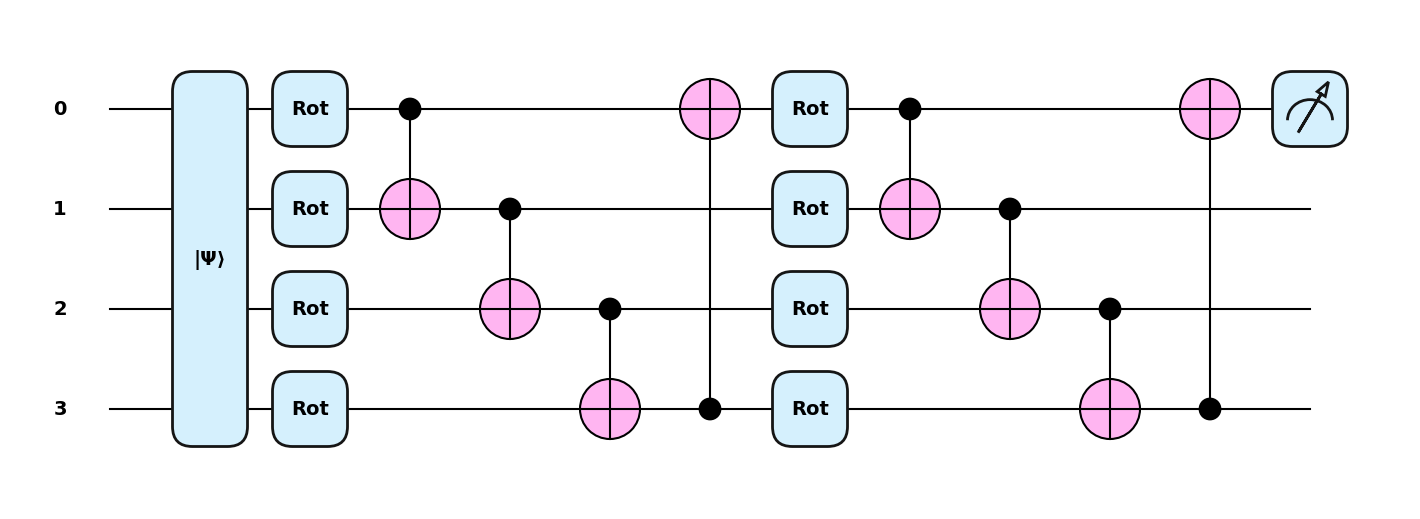

In [38]:
# Quantum circuit represented by Pennylane
qml.drawer.use_style("pennylane")
fig, ax = qml.draw_mpl(circuit)(weights, X_train[0]) # parameters given to the quantum circuit

# Etapa de Funcion de pérdida

In [39]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss


# Etapa de evaluación de la Función de Costo

In [40]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

# Etapa de Análisis de Precisión

In [41]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

# Pesos iniciales definidos

In [42]:
# setting init params
np.random.seed(0)
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

In [43]:
print(weights_init)

[[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]


# Entrenamiento

In [44]:
opt = AdamOptimizer(0.125)
num_it = 70
batch_size = math.floor(len(X_train)/num_it)

In [27]:
weights = weights_init
bias = bias_init
for it in range(num_it):

    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, len(X_train), (batch_size,))
    X_batch = X_train[batch_index]
    Y_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_train]
    acc = accuracy(Y_train, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X_train, Y_train), acc
        )
    )

Iter:     1 | Cost: 2.3009054 | Accuracy: 0.3657928 
Iter:     2 | Cost: 2.0157333 | Accuracy: 0.3657928 
Iter:     3 | Cost: 1.6928554 | Accuracy: 0.3657928 
Iter:     4 | Cost: 1.4394783 | Accuracy: 0.3657928 
Iter:     5 | Cost: 1.2992964 | Accuracy: 0.5205993 
Iter:     6 | Cost: 1.2592430 | Accuracy: 0.6167291 
Iter:     7 | Cost: 1.2860673 | Accuracy: 0.6167291 
Iter:     8 | Cost: 1.3340117 | Accuracy: 0.6167291 
Iter:     9 | Cost: 1.3157367 | Accuracy: 0.6167291 
Iter:    10 | Cost: 1.2278186 | Accuracy: 0.6167291 
Iter:    11 | Cost: 1.1070846 | Accuracy: 0.6167291 
Iter:    12 | Cost: 1.0319251 | Accuracy: 0.6167291 
Iter:    13 | Cost: 0.9932298 | Accuracy: 0.6167291 
Iter:    14 | Cost: 0.9745684 | Accuracy: 0.6167291 
Iter:    15 | Cost: 0.9807690 | Accuracy: 0.7802747 
Iter:    16 | Cost: 0.9487227 | Accuracy: 0.7802747 
Iter:    17 | Cost: 0.9169272 | Accuracy: 0.7802747 
Iter:    18 | Cost: 0.8685417 | Accuracy: 0.7802747 
Iter:    19 | Cost: 0.8121101 | Accuracy: 0.78

# Pesos Finales entrenados

In [30]:
print(weights)

[[[ 1.76405224e-02  1.62072071e+00  4.53474515e-01]
  [ 2.24089327e-02  1.94456302e+00 -2.15431674e+00]
  [ 9.50088443e-03  1.20709542e+00  1.16574675e-01]
  [ 4.10598424e-03  4.34849692e-01 -5.29636512e-02]]

 [[ 7.61037678e-03  1.21675034e-03  4.43863185e-03]
  [-1.04693033e-01  1.44260145e+00 -2.05158137e-03]
  [ 1.49158955e+00 -2.13282131e+00 -2.55298986e-02]
  [ 1.84665689e+00  1.95568097e+00 -7.42164953e-03]]]


# Evaluación de desempeño del clasificador cuántico final.

In [31]:
X_test = np.array(X_test.values, requires_grad=False)
Y_test = np.array(y_test.values * 2 - np.ones(len(y_test)), requires_grad=False)

predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]


In [32]:
accuracy_score(Y_test, predictions)
precision_score(Y_test, predictions)
recall_score(Y_test, predictions)
f1_score(Y_test, predictions, average='macro')

0.7712374581939799

Entrenamiento - Accuracy: 0.7840200

Accuracy con datos de prueba: 0.7712